In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import cartopy.crs as ccrs 
from cartopy.util import add_cyclic

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-lh" / "data.nc")
ERA5_LH = ERA5["slhf"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
# Prepare data for plotting
Lon, Lat = np.meshgrid(ERA5_LH["longitude"], ERA5_LH["latitude"])
Data = ERA5_LH.data
Data_p, Lon_p, Lat_p = add_cyclic(Data, x=Lon, y=Lat, precision=0.00001)

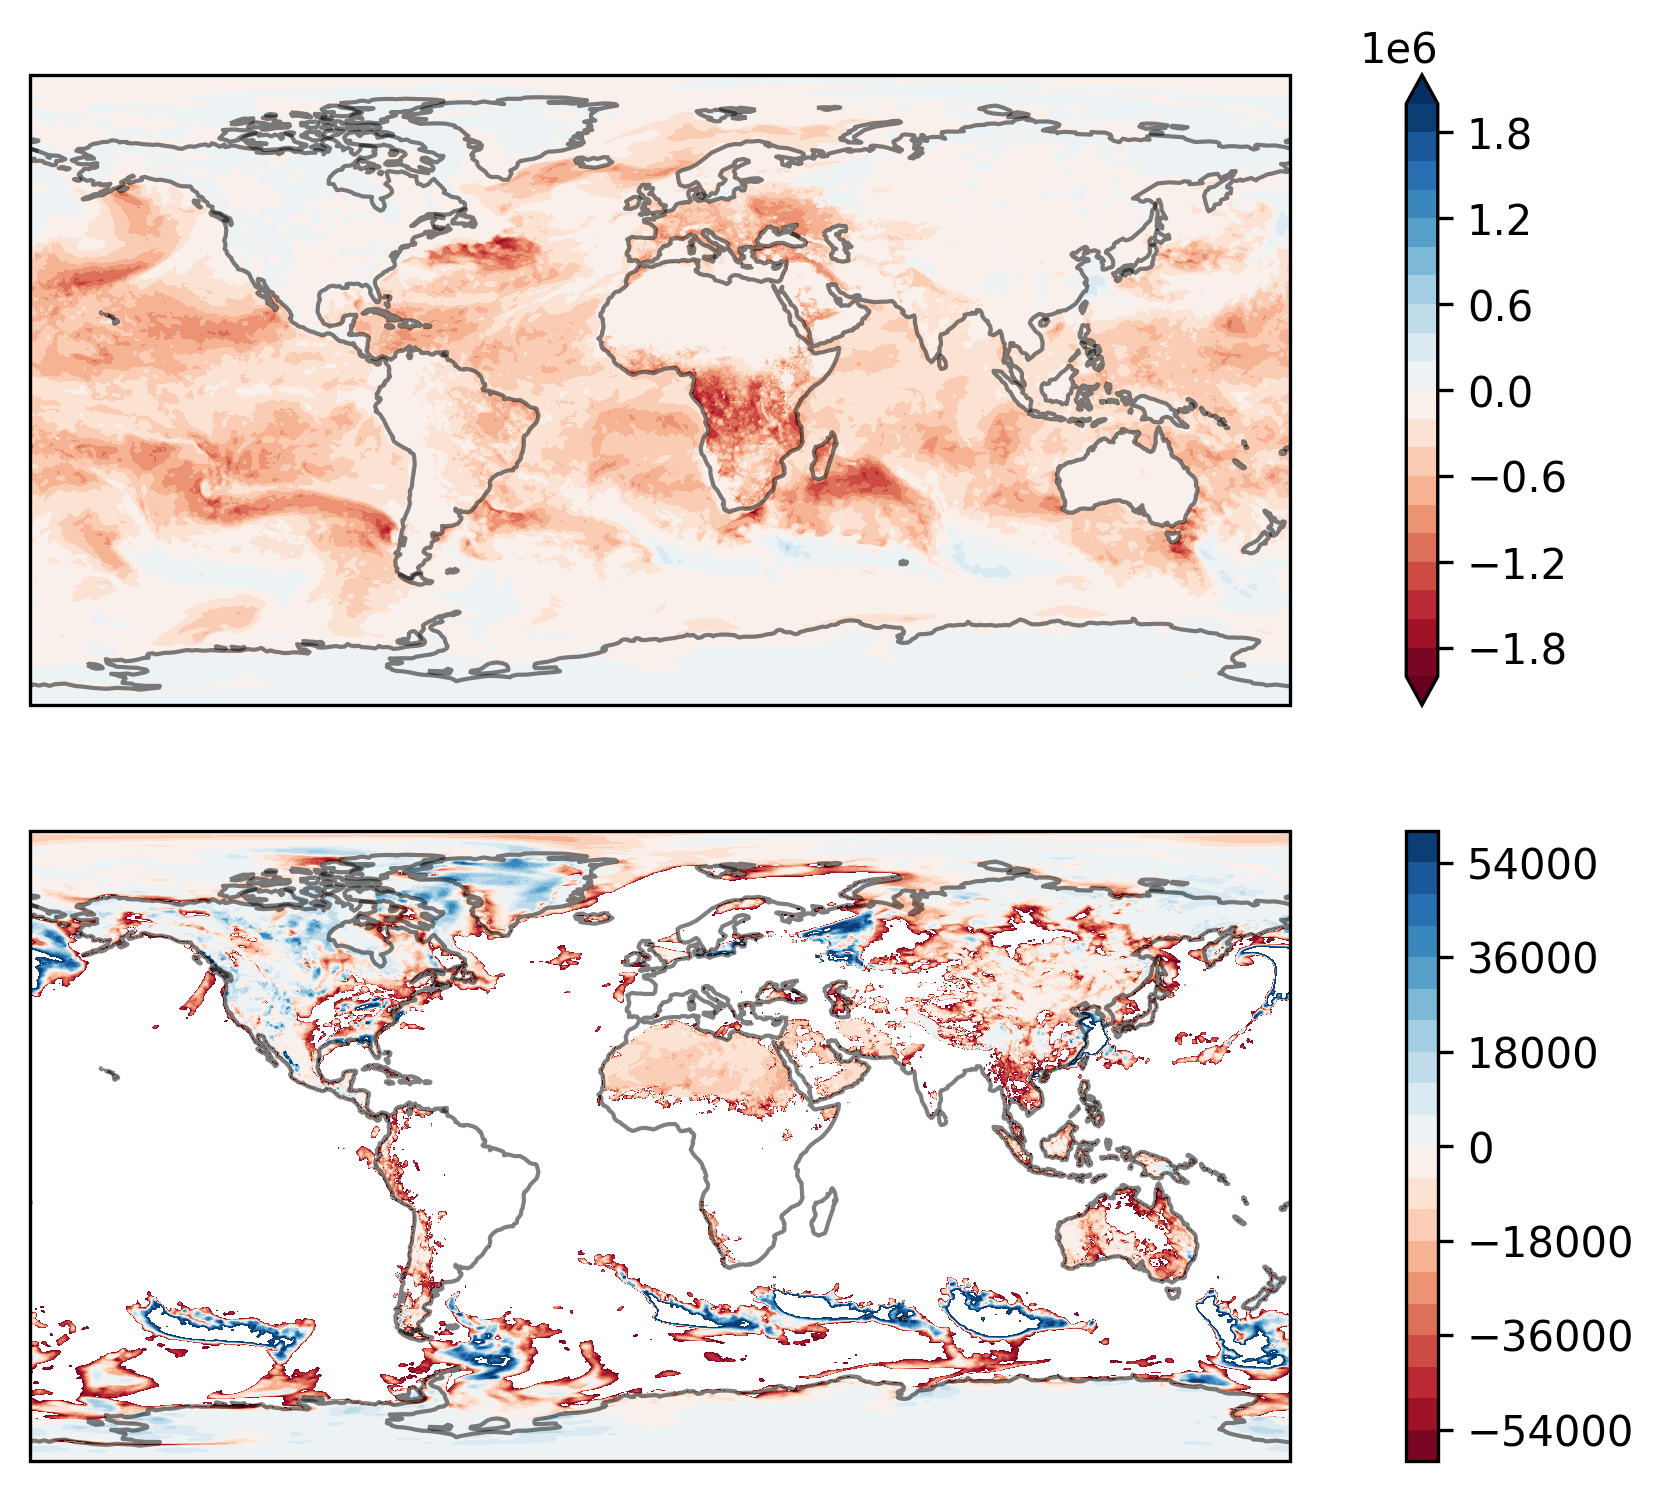

In [5]:
# Plotting 
fig = plt.figure(figsize=(10, 6), dpi=300)
ax1 = fig.add_subplot(2, 1, 1, projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection = ccrs.PlateCarree())


im1 = ax1.contourf(Lon_p, Lat_p, Data_p, transform = ccrs.PlateCarree(),
                   cmap= "RdBu",
                   extend="both", 
                   levels = np.arange(-2.0, 2.01, 0.2)*1E6)

cb1 = plt.colorbar(im1, ax=ax1)
ax1.coastlines(alpha=0.5)

im2 = ax2.contourf(Lon_p, Lat_p, Data_p, transform = ccrs.PlateCarree(), 
                   cmap= "RdBu",
                   extend="neither", 
                   levels = np.arange(-6.0, 6.01, 0.6)*1E4)

cb2 = plt.colorbar(im2, ax=ax2)
ax2.coastlines(alpha=0.5)

plt.show()